**https://www.kaggle.com/code/jamesleslie/titanic-neural-network-for-beginners/notebook**



<h1 id="Titanic-challenge-part-3">Titanic challenge part 3<a class="anchor-link" href="https://www.kaggle.com/code/jamesleslie/titanic-neural-network-for-beginners/notebook#Titanic-challenge-part-3" target="_self" rel=" noreferrer nofollow">¶</a></h1>
<p>In this notebook, we will be covering all of the steps required to train, tune and assess a neural network.</p>
<p><strong><a href="https://www.kaggle.com/jamesleslie/titanic-eda-wrangling-imputation">Part 1</a></strong> of this series dealt with the pre-processing and manipulation of the data. This notebook will make use of the datasets that were created in the first part.</p>
<p>We will do each of the following:</p>
<ul>
<li>train and test a neural network model</li>
<li>use grid search to optimize the hyperparameters</li>
<li>submit predictions for the test set</li>
</ul>
<p><strong><a href="https://www.kaggle.com/jamesleslie/titanic-random-forest-grid-search">Part 2</a></strong> covered the use of a random forest for tackling this challenge. Now let's see if we can beat that model with a neural network!</p>
<blockquote><p>NOTE: make sure to use a GPU for this notebook, as it will be significantly faster to train</p>
</blockquote>

In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt 
from matplotlib.pyplot import rcParams

# %matplotlib inline
# rcParams['figure.figsize'] = 10,8
# sns.set(style='whitegrid', palette='muted',
#         rc={'figure.figsize': (15,10)})

import os
from sklearn.preprocessing import StandardScaler
from numpy.random import seed
import tensorflow as tf 


# from keras.wrappers.scikit_learn import KerasClassifier
from keras.models import Sequential
from keras.layers import Dense, Activation, Dropout

# from tensorflow.keras.models import Sequential
# from tensorflow.keras.layers import Dense, Dropout
# from tensorflow.keras import optimizers

2023-09-25 19:10:04.386778: I tensorflow/core/util/port.cc:110] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2023-09-25 19:10:04.414801: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX_VNNI FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-09-25 19:10:04.902917: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


In [2]:
# Check hardware

print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))

 

visible_devices = tf.config.get_visible_devices()

for devices in visible_devices:

  print(devices)

Num GPUs Available:  1
PhysicalDevice(name='/physical_device:CPU:0', device_type='CPU')
PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')


2023-09-25 19:10:05.418308: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:981] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2023-09-25 19:10:05.452207: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:981] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2023-09-25 19:10:05.452255: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:981] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.


In [3]:
print(os.listdir("./data"))

['test_clean.csv:Zone.Identifier', 'test_clean.csv', 'test_clean.csv_Zone.Identifier', 'train_clean.csv', 'train_clean.csv_Zone.Identifier:Zone.Identifier', 'test_clean.csv_Zone.Identifier:Zone.Identifier', 'train_clean.csv:Zone.Identifier', 'train_clean.csv_Zone.Identifier']


In [4]:
# <!-- # Load data as Pandas dataframe -->
train = pd.read_csv('./data/train_clean.csv', )
test = pd.read_csv('./data/test_clean.csv')
df = pd.concat([train, test], axis=0, sort=True)

In [5]:
df.head()

,Age,Cabin,Embarked,Family_Size,Fare,Name,Parch,PassengerId,Pclass,Sex,SibSp,Survived,Ticket,Title
0,22.0,NaN,S,1,7.2500,"Braund, Mr. Owen Harris",0,1,3,male,1,0.0,A/5 21171,Mr
1,38.0,C85,C,1,71.2833,"Cumings, Mrs. John Bradley (Florence Briggs Th...",0,2,1,female,1,1.0,PC 17599,Mrs
2,26.0,NaN,S,0,7.9250,"Heikkinen, Miss. Laina",0,3,3,female,0,1.0,STON/O2. 3101282,Miss
3,35.0,C123,S,1,53.1000,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",0,4,1,female,1,1.0,113803,Mrs
4,35.0,NaN,S,0,8.0500,"Allen, Mr. William Henry",0,5,3,male,0,0.0,373450,Mr


In [6]:
def display_all(df):
    with pd.option_context("display.max_rows", 1000, "display.max_columns", 1000): 
        display(df)

        
display_all(df.describe(include='all').T)

,count,unique,top,freq,mean,std,min,25%,50%,75%,max
Age,1309.0,NaN,NaN,NaN,29.562391,13.16536,0.17,22.0,30.0,35.5,80.0
Cabin,295,186,C23 C25 C27,6,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Embarked,1309,3,S,915,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Family_Size,1309.0,NaN,NaN,NaN,0.883881,1.583639,0.0,0.0,0.0,1.0,10.0
Fare,1309.0,NaN,NaN,NaN,33.276193,51.743584,0.0,7.8958,14.4542,31.275,512.3292
Name,1309,1307,"Connolly, Miss. Kate",2,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Parch,1309.0,NaN,NaN,NaN,0.385027,0.86556,0.0,0.0,0.0,0.0,9.0
PassengerId,1309.0,NaN,NaN,NaN,655.0,378.020061,1.0,328.0,655.0,982.0,1309.0
Pclass,1309.0,NaN,NaN,NaN,2.294882,0.837836,1.0,2.0,3.0,3.0,3.0
Sex,1309,2,male,843,NaN,NaN,NaN,NaN,NaN,NaN,NaN


<div class="text_cell_render border-box-sizing rendered_html">
<p><a id="pre-processing"></a></p>
<h1 id="2.-Pre-processing">2. Pre-processing<a class="anchor-link" href="https://www.kaggle.com/code/jamesleslie/titanic-neural-network-for-beginners/notebook#2.-Pre-processing" target="_self" rel=" noreferrer nofollow">¶</a></h1><p><a id="encoding"></a></p>
<h2 id="2.1.-Encode-Categorical-Variables">2.1. Encode Categorical Variables<a class="anchor-link" href="https://www.kaggle.com/code/jamesleslie/titanic-neural-network-for-beginners/notebook#2.1.-Encode-Categorical-Variables" target="_self" rel=" noreferrer nofollow">¶</a></h2><p>We need to convert all categorical variables into numeric format. The categorical variables we will be keeping are <code>Embarked</code>, <code>Sex</code> and <code>Title</code>.</p>
<p>The <code>Sex</code> variable can be encoded into single 1-or-0 column, but the other variables will need to be <a href="https://hackernoon.com/what-is-one-hot-encoding-why-and-when-do-you-have-to-use-it-e3c6186d008f" rel=" noreferrer nofollow">one-hot encoded</a>. Regular label encoding assigns some category labels higher numerical values. This implies some sort of scale (Embarked = 1 is not <strong>more</strong> than Embarked = 0 - it's just <em>different</em>). One Hot Encoding avoids this problem.</p>
<p>We will assume that there is some ordinality in the <code>Pclass</code> variable, so we will leave that as a single column.</p>

</div>

(array([0, 1, 2]), [Text(0, 0, '1'), Text(1, 0, '2'), Text(2, 0, '3')])

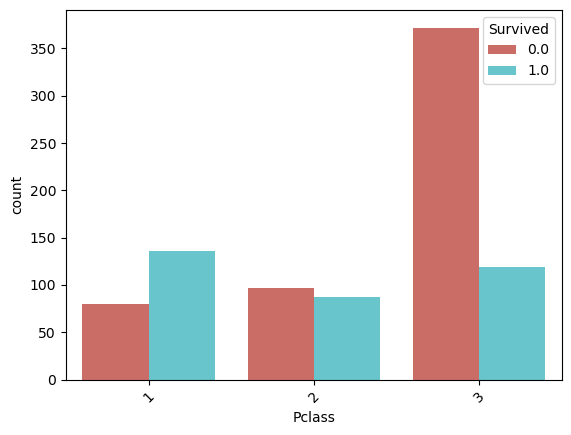

In [7]:
sns.countplot(x='Pclass', data=df, palette='hls', hue='Survived')
plt.xticks(rotation=45)
# plt.show()

<Axes: xlabel='Sex', ylabel='count'>

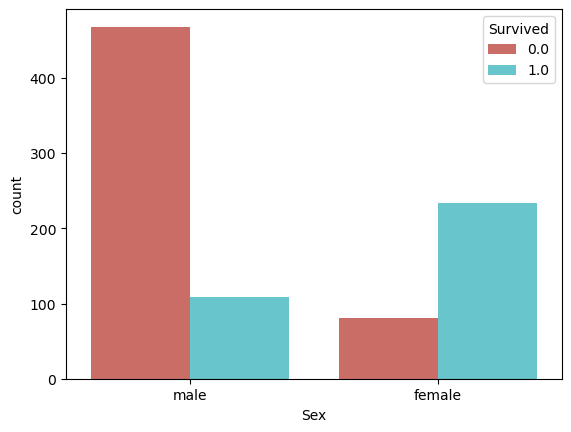

In [8]:
sns.countplot(x='Sex', data=df, palette='hls', hue='Survived')
# plt.xticks(rotation=45)
# plt.show()

<Axes: xlabel='Embarked', ylabel='count'>

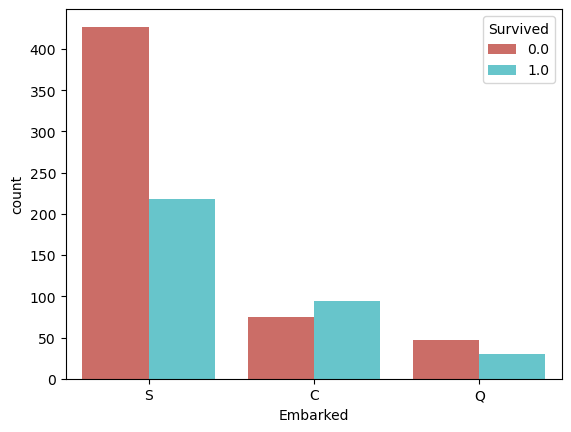

In [9]:
sns.countplot(x='Embarked', data=df, palette='hls', hue='Survived')
# plt.xticks(rotation=45)
# plt.show()

In [10]:
# convert to cateogry dtype
df['Sex'] = df['Sex'].astype('category')
# convert to category codes
df['Sex'] = df['Sex'].cat.codes

In [11]:
# subset all categorical variables which need to be encoded
categorical = ['Embarked', 'Title']

for var in categorical:
    df = pd.concat([df, 
                    pd.get_dummies(df[var], prefix=var , dtype=float)], axis=1)
    del df[var]

In [12]:
# drop the variables we won't be using
df.drop(['Cabin', 'Name', 'Ticket', 'PassengerId'], axis=1, inplace=True)


In [13]:
df.head()

,Age,Family_Size,Fare,Parch,Pclass,Sex,SibSp,Survived,Embarked_C,Embarked_Q,Embarked_S,Title_Dr,Title_Master,Title_Miss,Title_Mr,Title_Mrs,Title_Rev
0,22.0,1,7.2500,0,3,1,1,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0
1,38.0,1,71.2833,0,1,0,1,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
2,26.0,0,7.9250,0,3,0,0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0
3,35.0,1,53.1000,0,1,0,1,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0
4,35.0,0,8.0500,0,3,1,0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0


<h2 id="2.2.-Scale-Continuous-Variables">2.2. Scale Continuous Variables<a class="anchor-link" href="https://www.kaggle.com/code/jamesleslie/titanic-neural-network-for-beginners/notebook#2.2.-Scale-Continuous-Variables" target="_self" rel=" noreferrer nofollow">¶</a></h2>
<p>The continuous variables need to be scaled. This is done using a standard scaler from SkLearn.</p>

In [14]:
continuous = ['Age', 'Fare', 'Parch', 'Pclass', 'SibSp', 'Family_Size']

scaler = StandardScaler()

for var in continuous:
    df[var] = df[var].astype('float64')
    df[var] = scaler.fit_transform(df[var].values.reshape(-1, 1))

In [15]:
df.head()

,Age,Family_Size,Fare,Parch,Pclass,Sex,SibSp,Survived,Embarked_C,Embarked_Q,Embarked_S,Title_Dr,Title_Master,Title_Miss,Title_Mr,Title_Mrs,Title_Rev
0,-0.574635,0.073352,-0.503176,-0.445,0.841916,1,0.481288,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0
1,0.641140,0.073352,0.734809,-0.445,-1.546098,0,0.481288,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
2,-0.270692,-0.558346,-0.490126,-0.445,0.841916,0,-0.479087,1.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0
3,0.413182,0.073352,0.383263,-0.445,-1.546098,0,0.481288,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0
4,0.413182,-0.558346,-0.487709,-0.445,0.841916,1,-0.479087,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0


In [16]:
display_all(df.describe(include='all').T)

,count,mean,std,min,25%,50%,75%,max
Age,1309.0,7.327981e-17,1.000382,-2.233408,-0.574635,0.033252,0.451175,3.832549
Family_Size,1309.0,1.628440e-17,1.000382,-0.558346,-0.558346,-0.558346,0.073352,5.758637
Fare,1309.0,2.171254e-17,1.000382,-0.643344,-0.490691,-0.363894,-0.038690,9.261749
Parch,1309.0,1.730218e-17,1.000382,-0.445000,-0.445000,-0.445000,-0.445000,9.956864
Pclass,1309.0,-2.062691e-16,1.000382,-1.546098,-0.352091,0.841916,0.841916,0.841916
Sex,1309.0,6.440031e-01,0.478997,0.000000,0.000000,1.000000,1.000000,1.000000
SibSp,1309.0,-1.628440e-17,1.000382,-0.479087,-0.479087,-0.479087,0.481288,7.203909
Survived,891.0,3.838384e-01,0.486592,0.000000,0.000000,0.000000,1.000000,1.000000
Embarked_C,1309.0,2.070283e-01,0.405331,0.000000,0.000000,0.000000,0.000000,1.000000
Embarked_Q,1309.0,9.396486e-02,0.291891,0.000000,0.000000,0.000000,0.000000,1.000000


<h1 id="3.-Neural-Network">3. Neural Network<a class="anchor-link" href="https://www.kaggle.com/code/jamesleslie/titanic-neural-network-for-beginners/notebook#3.-Neural-Network" target="_self" rel=" noreferrer nofollow">¶</a></h1>
<p>Now, all that is left is to feed our data that has been cleaned, encoded and scaled to our neural network.</p>
<p>But first, we need to separate <em>data_df</em> back into <em>train</em> and <em>test</em> sets.</p>

In [17]:
X_train = df[pd.notnull(df['Survived'])].drop(['Survived'], axis=1)
y_train = df[pd.notnull(df['Survived'])]['Survived']
X_test = df[pd.isnull(df['Survived'])].drop(['Survived'], axis=1)


<h2>3.1. Cross-validation<a class="anchor-link" href="https://www.kaggle.com/code/jamesleslie/titanic-neural-network-for-beginners/notebook#3.1.-Cross-validation" target="_self" rel=" noreferrer nofollow">¶</a></h2><p>Keras allows us to make use of cross-validation for training our model. So we will use this to train and assess our first model.</p>

</div>
</div>


<div class="text_cell_render border-box-sizing rendered_html">
<h3 id="Create-neural-network-model">Create neural network model<a class="anchor-link" href="https://www.kaggle.com/code/jamesleslie/titanic-neural-network-for-beginners/notebook#Create-neural-network-model" target="_self" rel=" noreferrer nofollow">¶</a></h3><p>For this task, I have kept the model architecture pretty simple. We have one input layer with 17 nodes which feeds into a hidden layer with 8 nodes and an output layer which is used to predict a passenger's survival.</p>
<p>The output layer has a sigmoid activation function, which is used to 'squash' all our outputs to be between 0 and 1.</p>
<p>We are going to create a function which allows to parameterise the choice of hyperparameters in the neural network. This might seem a little overly complicated now, but it will come in super handy when we move onto tuning our parameters later.</p>

</div>

In [18]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 1309 entries, 0 to 417
Data columns (total 17 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   Age           1309 non-null   float64
 1   Family_Size   1309 non-null   float64
 2   Fare          1309 non-null   float64
 3   Parch         1309 non-null   float64
 4   Pclass        1309 non-null   float64
 5   Sex           1309 non-null   int8   
 6   SibSp         1309 non-null   float64
 7   Survived      891 non-null    float64
 8   Embarked_C    1309 non-null   float64
 9   Embarked_Q    1309 non-null   float64
 10  Embarked_S    1309 non-null   float64
 11  Title_Dr      1309 non-null   float64
 12  Title_Master  1309 non-null   float64
 13  Title_Miss    1309 non-null   float64
 14  Title_Mr      1309 non-null   float64
 15  Title_Mrs     1309 non-null   float64
 16  Title_Rev     1309 non-null   float64
dtypes: float64(16), int8(1)
memory usage: 175.1 KB


In [19]:
def create_model(lyrs=[8], act='linear',  dr=0.0):
    
    # set random seed for reproducibility
    seed(42)
    tf.random.set_seed(42)
    # set_random_seed(42)
    
    model = Sequential()
    
    # create first hidden layer
    model.add(Dense(lyrs[0], input_dim=X_train.shape[1], activation=act))
    
    # create additional hidden layers
    for i in range(1,len(lyrs)):
        model.add(Dense(lyrs[i], activation=act))
    
    # add dropout, default is none
    model.add(Dropout(dr))
    
    # create output layer
    model.add(Dense(1, activation='sigmoid'))  # output layer
    # opt = tf.keras.optimizers.Adam(learning_rate=0.01)
    
    model.compile(loss='binary_crossentropy', optimizer=tf.keras.optimizers.Adam(learning_rate=0.01), metrics=['accuracy'])
 
    
    return model


In [20]:
model = create_model()
print(model.summary())

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 8)                 136       
                                                                 
 dropout (Dropout)           (None, 8)                 0         
                                                                 
 dense_1 (Dense)             (None, 1)                 9         
                                                                 
Total params: 145 (580.00 Byte)
Trainable params: 145 (580.00 Byte)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________
None


2023-09-25 19:10:06.108552: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:981] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2023-09-25 19:10:06.108636: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:981] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2023-09-25 19:10:06.108653: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:981] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2023-09-25 19:10:06.693105: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:981] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2023-09-25 19:10:06.693169: I tensorflow/compile

In [21]:
# print(tensorflow.__version__)

In [22]:
# train model on full train set, with 80/20 CV split

# training = model.fit(X_train, y_train, epochs=10, batch_size=32, validation_split=0.2, verbose=0)
training = model.fit(X_train, y_train, epochs=10, batch_size=32)

# val_acc = np.mean(training.history['val_acc'])
# print("\n%s: %.2f%%" % ('val_acc', val_acc*100))


Epoch 1/10


2023-09-25 19:10:08.252815: I tensorflow/compiler/xla/stream_executor/cuda/cuda_blas.cc:606] TensorFloat-32 will be used for the matrix multiplication. This will only be logged once.
2023-09-25 19:10:08.257345: I tensorflow/compiler/xla/service/service.cc:168] XLA service 0x7fd4e3056d90 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
2023-09-25 19:10:08.257372: I tensorflow/compiler/xla/service/service.cc:176]   StreamExecutor device (0): NVIDIA GeForce RTX 3060, Compute Capability 8.6
2023-09-25 19:10:08.262383: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:255] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
2023-09-25 19:10:08.388142: I tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:432] Loaded cuDNN version 8600
2023-09-25 19:10:08.396539: W tensorflow/compiler/xla/service/gpu/llvm_gpu_backend/gpu_backend_lib.cc:543] Can't find libdevice directory ${CUDA_DIR}/nvvm/libdevice. 

InternalError: Graph execution error:

Detected at node 'Adam/StatefulPartitionedCall_2' defined at (most recent call last):
    File "/home/nour_gpu/miniconda3/envs/tf/lib/python3.9/runpy.py", line 197, in _run_module_as_main
      return _run_code(code, main_globals, None,
    File "/home/nour_gpu/miniconda3/envs/tf/lib/python3.9/runpy.py", line 87, in _run_code
      exec(code, run_globals)
    File "/home/nour_gpu/miniconda3/envs/tf/lib/python3.9/site-packages/ipykernel_launcher.py", line 17, in <module>
      app.launch_new_instance()
    File "/home/nour_gpu/miniconda3/envs/tf/lib/python3.9/site-packages/traitlets/config/application.py", line 992, in launch_instance
      app.start()
    File "/home/nour_gpu/miniconda3/envs/tf/lib/python3.9/site-packages/ipykernel/kernelapp.py", line 736, in start
      self.io_loop.start()
    File "/home/nour_gpu/miniconda3/envs/tf/lib/python3.9/site-packages/tornado/platform/asyncio.py", line 195, in start
      self.asyncio_loop.run_forever()
    File "/home/nour_gpu/miniconda3/envs/tf/lib/python3.9/asyncio/base_events.py", line 601, in run_forever
      self._run_once()
    File "/home/nour_gpu/miniconda3/envs/tf/lib/python3.9/asyncio/base_events.py", line 1905, in _run_once
      handle._run()
    File "/home/nour_gpu/miniconda3/envs/tf/lib/python3.9/asyncio/events.py", line 80, in _run
      self._context.run(self._callback, *self._args)
    File "/home/nour_gpu/miniconda3/envs/tf/lib/python3.9/site-packages/ipykernel/kernelbase.py", line 516, in dispatch_queue
      await self.process_one()
    File "/home/nour_gpu/miniconda3/envs/tf/lib/python3.9/site-packages/ipykernel/kernelbase.py", line 505, in process_one
      await dispatch(*args)
    File "/home/nour_gpu/miniconda3/envs/tf/lib/python3.9/site-packages/ipykernel/kernelbase.py", line 412, in dispatch_shell
      await result
    File "/home/nour_gpu/miniconda3/envs/tf/lib/python3.9/site-packages/ipykernel/kernelbase.py", line 740, in execute_request
      reply_content = await reply_content
    File "/home/nour_gpu/miniconda3/envs/tf/lib/python3.9/site-packages/ipykernel/ipkernel.py", line 422, in do_execute
      res = shell.run_cell(
    File "/home/nour_gpu/miniconda3/envs/tf/lib/python3.9/site-packages/ipykernel/zmqshell.py", line 546, in run_cell
      return super().run_cell(*args, **kwargs)
    File "/home/nour_gpu/miniconda3/envs/tf/lib/python3.9/site-packages/IPython/core/interactiveshell.py", line 3024, in run_cell
      result = self._run_cell(
    File "/home/nour_gpu/miniconda3/envs/tf/lib/python3.9/site-packages/IPython/core/interactiveshell.py", line 3079, in _run_cell
      result = runner(coro)
    File "/home/nour_gpu/miniconda3/envs/tf/lib/python3.9/site-packages/IPython/core/async_helpers.py", line 129, in _pseudo_sync_runner
      coro.send(None)
    File "/home/nour_gpu/miniconda3/envs/tf/lib/python3.9/site-packages/IPython/core/interactiveshell.py", line 3284, in run_cell_async
      has_raised = await self.run_ast_nodes(code_ast.body, cell_name,
    File "/home/nour_gpu/miniconda3/envs/tf/lib/python3.9/site-packages/IPython/core/interactiveshell.py", line 3466, in run_ast_nodes
      if await self.run_code(code, result, async_=asy):
    File "/home/nour_gpu/miniconda3/envs/tf/lib/python3.9/site-packages/IPython/core/interactiveshell.py", line 3526, in run_code
      exec(code_obj, self.user_global_ns, self.user_ns)
    File "/tmp/ipykernel_123998/3824341642.py", line 4, in <module>
      training = model.fit(X_train, y_train, epochs=10, batch_size=32)
    File "/home/nour_gpu/miniconda3/envs/tf/lib/python3.9/site-packages/keras/src/utils/traceback_utils.py", line 65, in error_handler
      return fn(*args, **kwargs)
    File "/home/nour_gpu/miniconda3/envs/tf/lib/python3.9/site-packages/keras/src/engine/training.py", line 1742, in fit
      tmp_logs = self.train_function(iterator)
    File "/home/nour_gpu/miniconda3/envs/tf/lib/python3.9/site-packages/keras/src/engine/training.py", line 1338, in train_function
      return step_function(self, iterator)
    File "/home/nour_gpu/miniconda3/envs/tf/lib/python3.9/site-packages/keras/src/engine/training.py", line 1322, in step_function
      outputs = model.distribute_strategy.run(run_step, args=(data,))
    File "/home/nour_gpu/miniconda3/envs/tf/lib/python3.9/site-packages/keras/src/engine/training.py", line 1303, in run_step
      outputs = model.train_step(data)
    File "/home/nour_gpu/miniconda3/envs/tf/lib/python3.9/site-packages/keras/src/engine/training.py", line 1084, in train_step
      self.optimizer.minimize(loss, self.trainable_variables, tape=tape)
    File "/home/nour_gpu/miniconda3/envs/tf/lib/python3.9/site-packages/keras/src/optimizers/optimizer.py", line 544, in minimize
      self.apply_gradients(grads_and_vars)
    File "/home/nour_gpu/miniconda3/envs/tf/lib/python3.9/site-packages/keras/src/optimizers/optimizer.py", line 1230, in apply_gradients
      return super().apply_gradients(grads_and_vars, name=name)
    File "/home/nour_gpu/miniconda3/envs/tf/lib/python3.9/site-packages/keras/src/optimizers/optimizer.py", line 652, in apply_gradients
      iteration = self._internal_apply_gradients(grads_and_vars)
    File "/home/nour_gpu/miniconda3/envs/tf/lib/python3.9/site-packages/keras/src/optimizers/optimizer.py", line 1260, in _internal_apply_gradients
      return tf.__internal__.distribute.interim.maybe_merge_call(
    File "/home/nour_gpu/miniconda3/envs/tf/lib/python3.9/site-packages/keras/src/optimizers/optimizer.py", line 1352, in _distributed_apply_gradients_fn
      distribution.extended.update(
    File "/home/nour_gpu/miniconda3/envs/tf/lib/python3.9/site-packages/keras/src/optimizers/optimizer.py", line 1347, in apply_grad_to_update_var
      return self._update_step_xla(grad, var, id(self._var_key(var)))
Node: 'Adam/StatefulPartitionedCall_2'
libdevice not found at ./libdevice.10.bc
	 [[{{node Adam/StatefulPartitionedCall_2}}]] [Op:__inference_train_function_812]